# __Springboard Data Science Capstone 3 Project__
# _Predicting the Price of Energy_

### Pre-Processing & Modeling

##### _Ben Takacs_
###### __Python version 3.10.4__

### __Imports and File Location__

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import load_csv_data, arima_mse, model_eval

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

### __Load Data__

In [15]:
df = pd.read_csv('./data/df1.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df

,"Average Price of Electricity to Ultimate Customers, Residential",Total Renewable Energy Consumption,Total Petroleum Consumed by the Residential Sector,Natural Gas Consumed by the Electric Power Sector,"Natural Gas Consumed by the Transportation Sector, Vehicle Fuel"
Month,,,,,
1990-02-01,7.48,0.321465,143.972,153.181,0.021
1990-03-01,7.57,0.353956,129.117,214.167,0.023
1990-04-01,7.69,0.334136,108.024,231.641,0.022
1990-05-01,7.96,0.317791,94.930,283.776,0.023
1990-06-01,8.10,0.289276,87.671,345.768,0.022
...,...,...,...,...,...
2024-05-01,16.43,0.758321,53.691,1045.631,4.514
2024-06-01,16.42,0.742351,40.900,1243.853,4.368
2024-07-01,16.63,0.733689,31.619,1534.444,4.514


Average price is in units of cents per kilowatt hour, including taxes.\
Renewable energy consumption is in units of quadrillion Btu (10^15)\
Petroleum consumption is in units of trillion Btu (10^12)\
Natural gas consumed is in units of billion cubic feet (10^12)\
Need to convert  energies to same unit.
Also going to rename columsn to something easier.

In [16]:
df.rename(columns={'Average Price of Electricity to Ultimate Customers, Residential':'Price', 'Total Renewable Energy Consumption':'Renewable', 'Total Petroleum Consumed by the Residential Sector':'Petroleum', 'Natural Gas Consumed by the Electric Power Sector':'Electric', 'Natural Gas Consumed by the Transportation Sector, Vehicle Fuel':'Transportation'}, inplace=True)
df.Renewable *= 1e3
df

,Price,Renewable,Petroleum,Electric,Transportation
Month,,,,,
1990-02-01,7.48,321.465,143.972,153.181,0.021
1990-03-01,7.57,353.956,129.117,214.167,0.023
1990-04-01,7.69,334.136,108.024,231.641,0.022
1990-05-01,7.96,317.791,94.930,283.776,0.023
1990-06-01,8.10,289.276,87.671,345.768,0.022
...,...,...,...,...,...
2024-05-01,16.43,758.321,53.691,1045.631,4.514
2024-06-01,16.42,742.351,40.900,1243.853,4.368
2024-07-01,16.63,733.689,31.619,1534.444,4.514


Renewable and Petroleum now have same units (trillion Btu)

##### Don't need to scale data because it's a time series

### __Test Train Split__

In [53]:
# 65/35 test train split on data
split = 0.65
split_year = df.index.year[0] + int(split * (df.index.year[-1] - df.index.year[0]))    # find 60% of yearspan
train = df[df.index < str(split_year)]  # split data
test = df[df.index >= str(split_year)]
# print(train, test)

# Split x and y into train and test
xtrain = train.drop(columns=['Price'])
xtest = test.drop(columns=['Price'])
ytrain = train.Price
ytest = test.Price
print(xtrain, xtest, ytrain, ytest)

            Renewable  Petroleum  Electric  Transportation
Month                                                     
1990-02-01    321.465    143.972   153.181           0.021
1990-03-01    353.956    129.117   214.167           0.023
1990-04-01    334.136    108.024   231.641           0.022
1990-05-01    317.791     94.930   283.776           0.023
1990-06-01    289.276     87.671   345.768           0.022
...               ...        ...       ...             ...
2011-08-01    533.537     54.846   921.449           2.546
2011-09-01    493.388     60.497   684.198           2.464
2011-10-01    508.749     80.011   574.932           2.546
2011-11-01    517.794    101.189   542.546           2.464
2011-12-01    543.031    138.172   613.894           2.546

[263 rows x 4 columns]             Renewable  Petroleum  Electric  Transportation
Month                                                     
2012-01-01    517.856    132.363   648.823           2.538
2012-02-01    482.434    110.441

So train data is from 1990 to 2011, test data is from 2012 to 2024.

### __ARIMA Modeling__

Only takes one variable, price. 

In [67]:
model_price_1 = ARIMA(ytrain, order=(1,1,1))
model_price_1_fit = model_price_1.fit()
print(model_price_1_fit.summary())

model_price_2 = ARIMA(ytrain, order=(1,1,2))
model_price_2_fit = model_price_2.fit()
print(model_price_2_fit.summary())

aic_delta = model_price_2_fit.aic - model_price_1_fit.aic
print(aic_delta)

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  64.964
Date:                Thu, 13 Mar 2025   AIC                           -123.928
Time:                        12:55:11   BIC                           -113.223
Sample:                    02-01-1990   HQIC                          -119.625
                         - 12-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5435      0.094      5.756      0.000       0.358       0.728
ma.L1         -0.0052      0.113     -0.046      0.963      -0.226       0.216
sigma2         0.0356      0.003     12.105      0.0

Model of order (1,1,1) has lower AIC.

In [84]:
# Range of pdq values to test
p = [x for x in range(0, 3)]
d = [x for x in range(0, 3)]
q = [x for x in range(0, 3)]
# d = range(0, 3)
# q = range(0, 3)

aic_test = np.inf
for i in p:
    for j in d:
        for k in q:
            try:
                model = ARIMA(ytrain, order=(i, j, k))
                model_fit = model.fit()
                if model_fit.aic < aic_test:
                    aic_test = model_fit.aic
                    best_order_price = (i, j, k)
            except:
                continue

print('\nBest Order:', best_order_price)

# import warnings
# warnings.filterwarnings("ignore")
# best_order_price = model_eval(np.diff(ytrain), p, d, q)


Best Order: (2, 1, 2)


d = 1 means data was differenced once, as we expected.

In [77]:
model = ARIMA(ytrain, order=best_order_price)
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  263
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 153.421
Date:                Thu, 13 Mar 2025   AIC                           -296.843
Time:                        13:41:57   BIC                           -279.001
Sample:                    02-01-1990   HQIC                          -289.672
                         - 12-01-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7334      0.004    421.885      0.000       1.725       1.741
ar.L2         -0.9974      0.004   -270.717      0.000      -1.005      -0.990
ma.L1         -1.7774      0.023    -75.716      0.000      -1.823      -1.731
ma.L2          0.9888      0.026     37.778      0.000       0.938       1.040
sigma2         0.0175      0.002     11.604      0.000       0.015       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.39   Prob(JB):                         0.79
Heteroskedasticity (H):               2.60   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

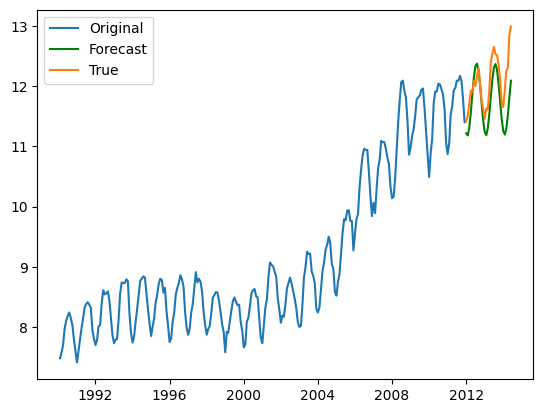

In [85]:
plt.figure()
plt.plot(ytrain, label='Original')
plt.plot(forecast, color='green', label='Forecast')
plt.plot(ytest[:30], label='True')
plt.legend()
plt.show()

This model underestimates trend of eneergy prices.

Future plans: Separate training and testing data using time series split.\
Modeling: ARIMA, SARIMA, FB Prophet, exponential smoothing
 RNN, XGBoost\
Employ 1 step ahead cross validation